In [1]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import scanpy as sc

In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [3]:
# dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
# dataset_meta = ['allen_'+x for x in ['B08']]
# dataset_names = [x for x in dataset_meta ]  
# raw_data_locations = [x for x in dataset_meta]
# transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

# loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
# n_datasets = len(loom_filepaths)


In [4]:
dataset_meta = 'pbmc_1k_v3'

In [5]:
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'

In [6]:
data_raw_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/adata.loom'

In [7]:
raw_data = sc.read_loom(data_raw_loc)

/home/ggorin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
thr_lb = 1e4

In [9]:
S_tot = np.squeeze(np.asarray(raw_data.layers[spliced_layer].sum(1)))
U_tot = np.squeeze(np.asarray(raw_data.layers[unspliced_layer].sum(1)))

In [10]:
S_tot.shape

(111231,)

In [11]:
def knee_plot(umi_sum, ax1=None, thr=None, viz=False):
    n_cells = len(umi_sum)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells), usf, "k")
        ax1.set_xlabel("Cell rank")
        ax1.set_ylabel("UMI count+1")
        ax1.set_yscale("log")
    if thr is not None:
        cf = umi_sum > thr
        rank_ = np.argmin(np.abs(usf - thr))
        if viz:
            ax1.plot([0, n_cells + 1], thr * np.ones(2), "r--")
            ys = ax1.get_ylim()
            ax1.plot(rank_ * np.ones(2), ys, "r--")
        return cf


array([False, False, False, ..., False, False, False])

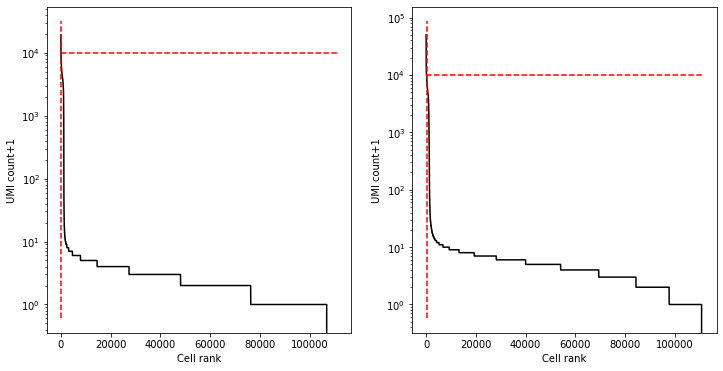

In [12]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot,ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot,ax1[1],viz=True,thr=thr_lb)


In [13]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)

In [14]:
cf = raw_data.obs['barcode'].isin(np.asarray(bcs_filtered).squeeze())

In [15]:
S_tot.shape

(111231,)

array([False, False, False, ..., False, False, False])

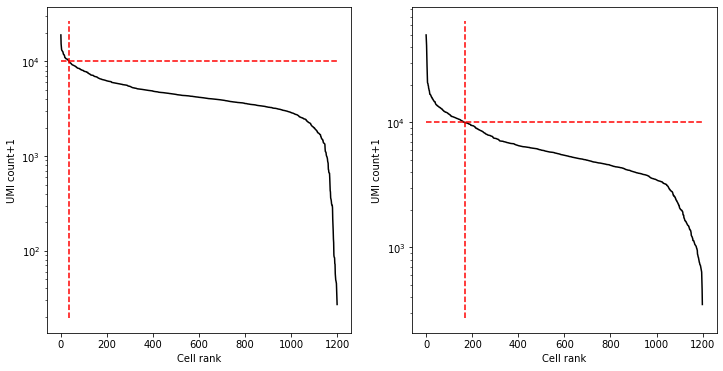

In [16]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[cf],ax1[1],viz=True,thr=thr_lb)


array([False, False, False, ..., False, False, False])

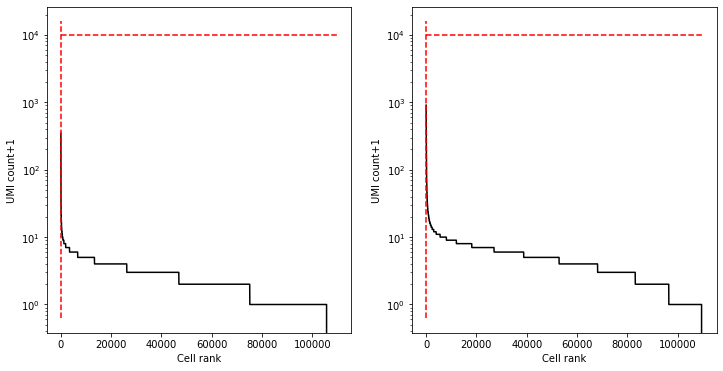

In [17]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[~cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[~cf],ax1[1],viz=True,thr=thr_lb)


In [18]:
np.var(raw_data.layers[spliced_layer][cf,:].todense(),0).shape

(1, 36601)

In [19]:
np.squeeze(np.var(raw_data.layers[spliced_layer][cf,:].todense(),0))

matrix([[0.00579931, 0.01315542, 0.00166389, ..., 0.00083265, 0.00914918,
         0.        ]], dtype=float32)

In [20]:
def plot_meanvar(X,cf_,ax):
    mean = np.squeeze(np.asarray(np.mean(X[cf_,:].todense(),0)))
    var = np.squeeze(np.asarray(np.var(X[cf_,:].todense(),0)))
    ax.scatter(mean,var,3,'k',alpha=0.4)
    xl = [min(mean),max(mean)]
    ax.plot(xl,xl,'r--')        
    ax.set_xscale("log")
    ax.set_yscale("log")

In [21]:
def plot_corr(X,Y,cf_,ax):
    corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[cf_].T,Y[cf_].T)])
    mean = np.squeeze(np.asarray(np.mean(X[cf_,:].todense(),0)))
    ax.scatter(mean,corrs,3,'k',alpha=0.4)
#     xl = [min(mean),max(mean)]
#     ax.plot(xl,xl,'r--')        
    ax.set_xscale("log")
    return corrs

In [22]:
def plot_mean_bg(X,cf_,ax):
#     corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[cf_].T,Y[cf_].T)])
    mean1 = np.squeeze((np.mean(X[cf_,:].toarray(),0)))
    mean2 = np.squeeze((np.mean(X[~cf_,:].toarray(),0)))
    
    lm1 = np.log10(mean1)
    lm2 = np.log10(mean2)
    gf = np.isfinite(lm1) & np.isfinite(lm2)
    
    lm1 = lm1[gf]
    lm2 = lm2[gf]
    
    ax.scatter(mean1,mean2,3,'k',alpha=0.4)
    xl = np.array([min(mean1),max(mean1)])
    ax.plot(xl,xl,'r--')        
    ax.plot(xl,xl*5e-4,'b--')        
    ax.set_xscale("log")
    ax.set_yscale("log")
    return np.corrcoef(lm1,lm2)[0][1]

In [23]:
raw_data

AnnData object with n_obs × n_vars = 111231 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [24]:
111231 -1200

110031

/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0, 0.5, 'Spliced/unspliced correlation')

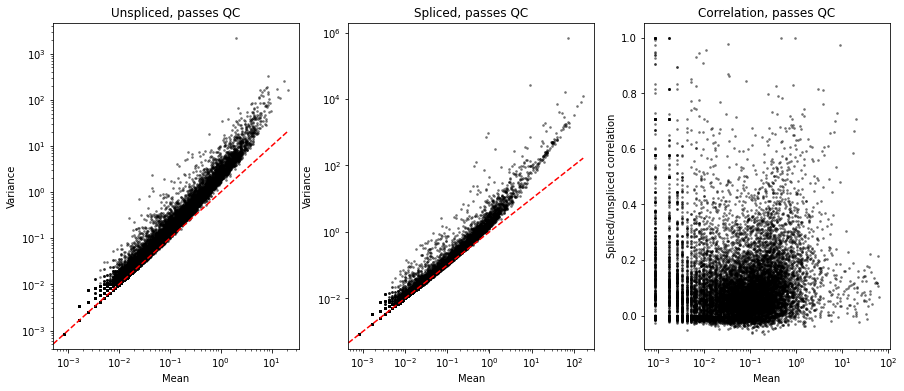

In [25]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))

plot_meanvar(raw_data.layers[unspliced_layer],cf,ax1[0])
ax1[0].set_title("Unspliced, passes QC")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(raw_data.layers[spliced_layer],cf,ax1[1])
ax1[1].set_title("Spliced, passes QC")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_qc = plot_corr(raw_data.layers[spliced_layer],raw_data.layers[unspliced_layer],cf,ax1[2])
ax1[2].set_title("Correlation, passes QC")
ax1[2].set_xlabel('Mean')
ax1[2].set_ylabel('Spliced/unspliced correlation')


Text(0, 0.5, 'Spliced/unspliced correlation')

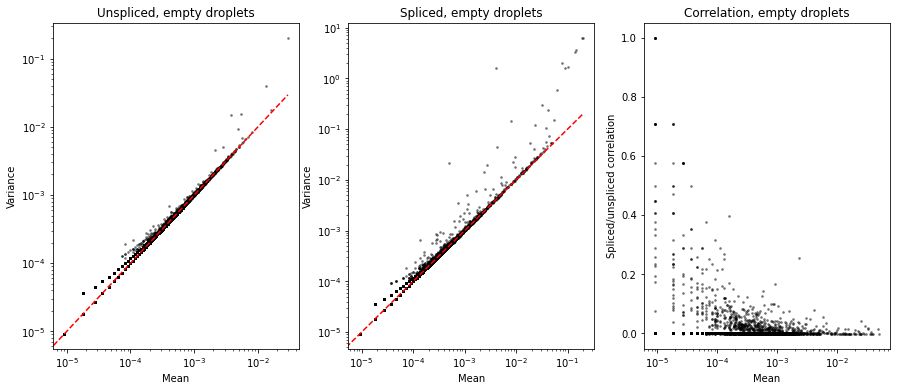

In [26]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))
plot_meanvar(raw_data.layers[unspliced_layer],~cf,ax1[0])
ax1[0].set_title("Unspliced, empty droplets")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(raw_data.layers[spliced_layer],~cf,ax1[1])
ax1[1].set_title("Spliced, empty droplets")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_empty = plot_corr(raw_data.layers[spliced_layer],raw_data.layers[unspliced_layer],~cf,ax1[2])
ax1[2].set_title("Correlation, empty droplets")
ax1[2].set_xlabel('Mean')
ax1[2].set_ylabel('Spliced/unspliced correlation')


Text(0, 0.5, 'Density')

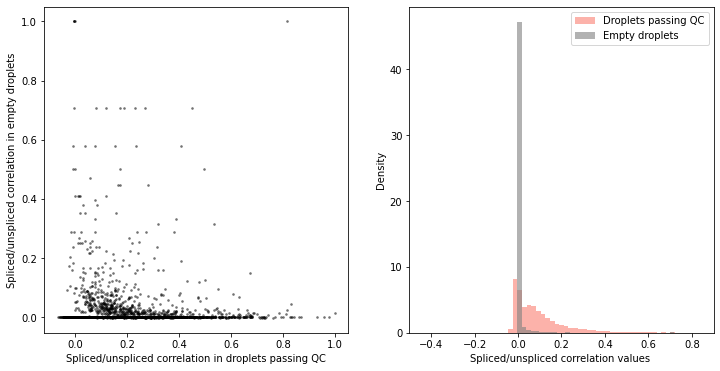

In [27]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
ax1[0].scatter(corrs_qc,corrs_empty,3,'k',alpha=0.4)
ax1[0].set_xlabel('Spliced/unspliced correlation in droplets passing QC')
ax1[0].set_ylabel('Spliced/unspliced correlation in empty droplets')

ax1[1].hist(corrs_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[1].legend()
ax1[1].set_xlim([-0.5,0.9])
ax1[1].set_xlabel('Spliced/unspliced correlation values ')
ax1[1].set_ylabel('Density')

/tmp/ipykernel_711333/73665729.py:6: RuntimeWarning: divide by zero encountered in log10
  lm1 = np.log10(mean1)
/tmp/ipykernel_711333/73665729.py:7: RuntimeWarning: divide by zero encountered in log10
  lm2 = np.log10(mean2)


Text(0, 0.5, 'Mean in empty droplets')

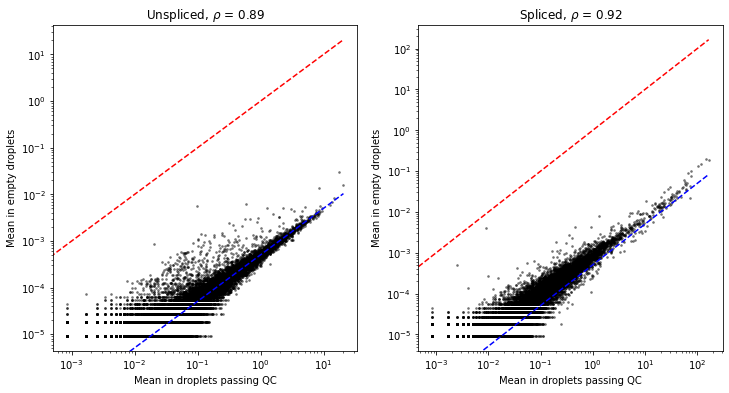

In [28]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
rho_U = plot_mean_bg(raw_data.layers[unspliced_layer],cf,ax1[0])
ax1[0].set_title(r"Unspliced, $\rho$ = {:.2f}".format(rho_U))
ax1[0].set_xlabel('Mean in droplets passing QC')
ax1[0].set_ylabel('Mean in empty droplets')

rho_S = plot_mean_bg(raw_data.layers[spliced_layer],cf,ax1[1])
ax1[1].set_title(r"Spliced, $\rho$ = {:.2f}".format(rho_S))
ax1[1].set_xlabel('Mean in droplets passing QC')
ax1[1].set_ylabel('Mean in empty droplets')

In [29]:
gf = (raw_data.layers[spliced_layer]).toarray().sum(0)>1

In [30]:
genecorr_qc = np.corrcoef(raw_data.layers[spliced_layer][cf][:,gf].T.toarray())
genecorr_qc = genecorr_qc[np.triu_indices(len(genecorr_qc),1)]

In [31]:
genecorr_empty = np.corrcoef(raw_data.layers[spliced_layer][~cf][:,gf].T.toarray())
genecorr_empty = genecorr_empty[np.triu_indices(len(genecorr_empty),1)]

Text(0, 0.5, 'Density')

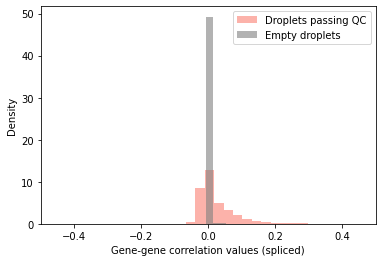

In [32]:
plt.hist(genecorr_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (spliced)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

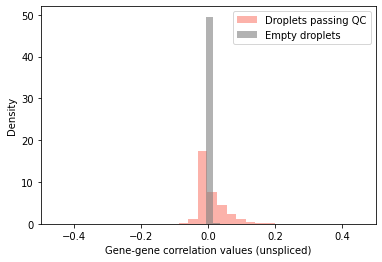

In [33]:
gf = (raw_data.layers[unspliced_layer]).toarray().sum(0)>1
genecorr_qc = np.corrcoef(raw_data.layers[unspliced_layer][cf][:,gf].T.toarray())
genecorr_qc = genecorr_qc[np.triu_indices(len(genecorr_qc),1)]
genecorr_empty = np.corrcoef(raw_data.layers[unspliced_layer][~cf][:,gf].T.toarray())
genecorr_empty = genecorr_empty[np.triu_indices(len(genecorr_empty),1)]
plt.hist(genecorr_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (unspliced)')
plt.ylabel('Density')

In [41]:
np.cov(raw_data.layers[spliced_layer][cf][:,gf].T.toarray()).shape

(15438, 15438)

In [47]:
gf = (raw_data.layers[spliced_layer]).toarray().sum(0)>1
genecov_qc = np.cov(raw_data.layers[spliced_layer][cf][:,gf].T.toarray())
genecov_qc = genecov_qc[np.triu_indices((genecov_qc).shape[1],1)]
# genecov_empty = np.cov(raw_data.layers[spliced_layer][~cf][:,gf].T.toarray())
# genecov_empty = genecorr_empty[np.triu_indices((genecorr_empty).shape[1],1)]


In [ ]:
genecov_empty = np.cov(raw_data.layers[spliced_layer][~cf][:,gf].T.toarray())


In [49]:
genecov_empty = genecov_empty[np.triu_indices((genecov_empty).shape[1],1)]


In [50]:
genecov_qc.shape

(119158203,)

In [51]:
genecov_empty.shape

(119158203,)

Text(0, 0.5, 'Density')

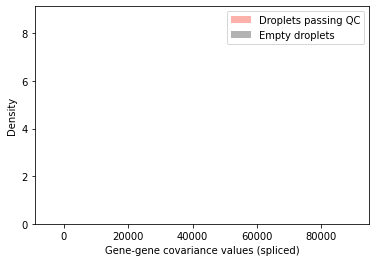

In [52]:
plt.hist(genecov_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecov_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
# plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene covariance values (spliced)')
plt.ylabel('Density')

In [ ]:
plt.scatter(genecov_qc,genecov_empty)

In [ ]:
genecov_qc

In [ ]:
print('hello')

In [ ]:
np.cov(raw_data.layers[spliced_layer][~cf][:,gf].toarray()).shape

In [ ]:
np.cov(raw_data.layers[spliced_layer][cf][:,gf].toarray()).shape

In [268]:
S_tot_qc = raw_data.layers[spliced_layer][cf].toarray().sum(1)
S_tot_empty = raw_data.layers[spliced_layer][~cf].toarray().sum(1)

In [276]:
S_tot_empty.shape

(110031,)

Text(0, 0.5, 'Density')

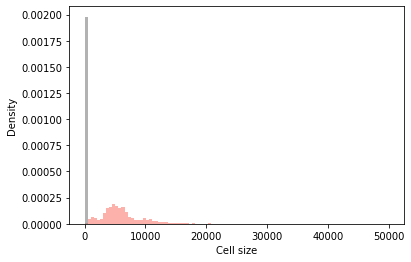

In [291]:
bins =np.linspace(-0.5,50000,100)
plt.hist(S_tot_qc,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(S_tot_empty,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.xlabel('Cell size')
plt.ylabel('Density')

In [308]:
S_tot_empty.var()

275.34988

In [309]:
S_tot_empty.mean()

5.509911

In [307]:
S_tot_qc.var()/S_tot_qc.mean()

2611.1611

In [354]:
S_fano_qc.shape

(1200,)

In [355]:
S_qc = raw_data.layers[spliced_layer][cf][:,gf].T.toarray()
S_mean_qc = S_qc.mean(1)
S_fano_qc = S_qc.var(1)/S_mean_qc
U_qc = raw_data.layers[unspliced_layer][cf][:,gf].T.toarray()
U_mean_qc = U_qc.mean(1)
U_fano_qc = U_qc.var(1)/U_mean_qc

/tmp/ipykernel_3737777/2414834893.py:3: RuntimeWarning: invalid value encountered in divide
  S_fano_qc = S_qc.var(1)/S_mean_qc
/tmp/ipykernel_3737777/2414834893.py:6: RuntimeWarning: invalid value encountered in divide
  U_fano_qc = U_qc.var(1)/U_mean_qc


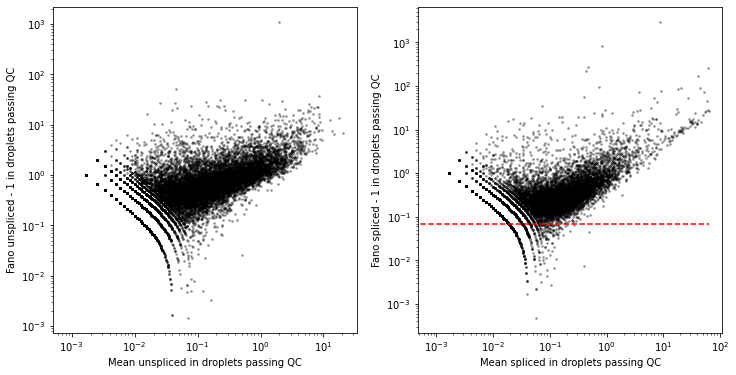

In [369]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))

ax1[0].scatter(U_mean_qc,U_fano_qc-1,3,'k',alpha=.3)
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Mean unspliced in droplets passing QC')
ax1[0].set_ylabel('Fano unspliced - 1 in droplets passing QC')

ax1[1].scatter(S_mean_qc,S_fano_qc-1,3,'k',alpha=.3)
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
ax1[1].set_xlabel('Mean spliced in droplets passing QC')
ax1[1].set_ylabel('Fano spliced - 1 in droplets passing QC')
xl = [S_mean_qc.min(),S_mean_qc.max()]
yl = [np.quantile(S_fano_qc[S_fano_qc>1]-1,0.05)]*2
ax1[1].plot(xl,yl,'r--')

In [364]:
# np.quantile(S_fano_qc[S_fano_qc>1]-1,0.01)

0.025502314567565916

In [372]:
S_empty = raw_data.layers[spliced_layer][~cf][:,gf].T.toarray()
S_mean_empty = S_empty.mean(1)
S_fano_empty = S_empty.var(1)/S_mean_empty
U_empty = raw_data.layers[unspliced_layer][~cf][:,gf].T.toarray()
U_mean_empty = U_empty.mean(1)
U_fano_empty = U_empty.var(1)/U_mean_empty


/tmp/ipykernel_3737777/2848294848.py:3: RuntimeWarning: invalid value encountered in divide
  S_fano_empty = S_empty.var(1)/S_mean_empty
/tmp/ipykernel_3737777/2848294848.py:6: RuntimeWarning: invalid value encountered in divide
  U_fano_empty = U_empty.var(1)/U_mean_empty


In [371]:
U_fano_empty.shape

(18575,)

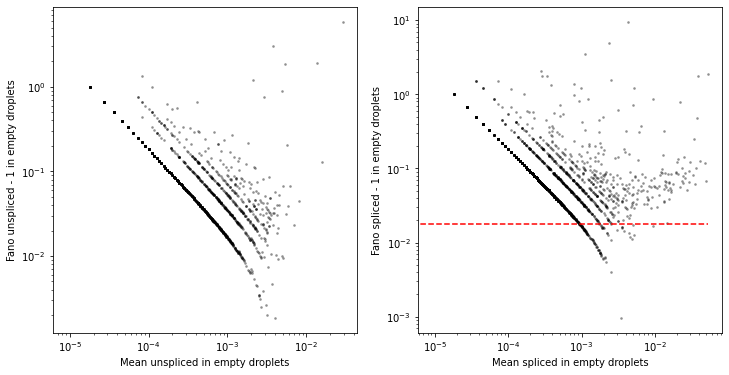

In [373]:

fig1,ax1 = plt.subplots(1,2,figsize=(12,6))


ax1[0].scatter(U_mean_empty,U_fano_empty-1,3,'k',alpha=.3)
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Mean unspliced in empty droplets')
ax1[0].set_ylabel('Fano unspliced - 1 in empty droplets')

ax1[1].scatter(S_mean_empty,S_fano_empty-1,3,'k',alpha=.3)
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
ax1[1].set_xlabel('Mean spliced in empty droplets')
ax1[1].set_ylabel('Fano spliced - 1 in empty droplets')
xl = [S_mean_empty.min(),S_mean_empty.max()]
yl = [np.quantile(S_fano_empty[S_fano_empty>1]-1,0.05)]*2
ax1[1].plot(xl,yl,'r--')

# ax1[0].scatter(S_mean_empty,S_fano_empty+1,3,'k',alpha=.6)
# ax1[0].set_xscale('log')
# ax1[0].set_yscale('log')
# ax1[0].set_xlabel('Mean spliced in empty droplets')
# ax1[0].set_ylabel('Fano spliced - 1 in empty droplets')

# ax1[1].scatter(U_mean_empty,U_fano_empty+1,3,'k',alpha=.6)
# ax1[1].set_xscale('log')
# ax1[1].set_yscale('log')
# ax1[1].set_xlabel('Mean unspliced in empty droplets')
# ax1[1].set_ylabel('Fano unspliced - 1 in empty droplets')

In [377]:
S_fano_empty[S_fano_empty>1].shape

(2131,)

In [382]:
raw_data.layers[spliced_layer]

<111231x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 2503715 stored elements in Compressed Sparse Row format>

In [415]:
# a e s t h e t i c s
fs = 12

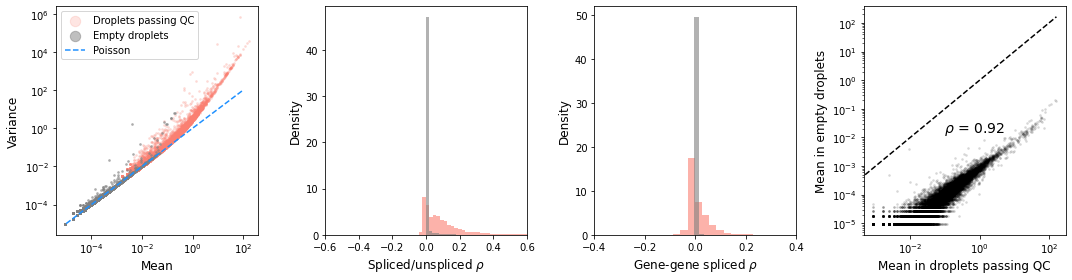

In [528]:
fig1,ax1 = plt.subplots(1,4,figsize=(15,4))

############
X = raw_data.layers[spliced_layer]

m1 = X[cf,:].mean(0).A1
v1 = X[cf,:].power(2).mean(0).A1-mean**2
m2 = X[~cf,:].mean(0).A1
v2 = X[~cf,:].power(2).mean(0).A1-mean**2

ax1[0].scatter(m1,v1,3,'salmon',alpha=0.2,label='Droplets passing QC')
ax1[0].scatter(m2,v2,3,'gray',alpha=0.5,label='Empty droplets')

xl = [1e-5,1e2]
ax1[0].plot(xl,xl,'--',c='dodgerblue',label='Poisson')        
ax1[0].set_xscale("log")
ax1[0].set_yscale("log")
ax1[0].set_xlabel('Mean',fontsize=fs)
ax1[0].set_ylabel('Variance',fontsize=fs)
ax1[0].legend(markerscale=6)

############
ax1[1].hist(corrs_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# ax1[1].legend()
ax1[1].set_xlim([-0.6,0.6])
ax1[1].set_xlabel(r'Spliced/unspliced $\rho$',fontsize=fs)
ax1[1].set_ylabel('Density',fontsize=fs)

#############

ax1[2].hist(genecorr_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[2].hist(genecorr_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# ax1[2].legend(loc='upper left')
ax1[2].set_xlim([-0.4,0.4])
ax1[2].set_xlabel(r'Gene-gene spliced $\rho$',fontsize=fs)
ax1[2].set_ylabel('Density',fontsize=fs)
    
#############
gf = (m1>0) & (m2>0)
lm1 = np.log10(m1[gf])
lm2 = np.log10(m2[gf])


ax1[3].scatter(m1,m2,3,'k',alpha=0.1)
xl = np.array([min(m1),max(m1)])
ax1[3].plot(xl,xl,'k--')        
ax1[3].set_xscale("log")
ax1[3].set_yscale("log")
ax1[3].text(0.4,0.45,r'$\rho$ = {:.2f}'.format(np.corrcoef(lm1,lm2)[0][1]),transform=ax1[3].transAxes,fontsize=fs+2)
ax1[3].set_xlabel('Mean in droplets passing QC',fontsize=fs)
ax1[3].set_ylabel('Mean in empty droplets',fontsize=fs)


fig1.tight_layout()


In [531]:
gf.sum()

11650

In [529]:
(~np.isnan(genecorr_empty)).sum()

95323528

In [530]:
(~np.isnan(genecorr_qc)).sum()

172208961

In [526]:
(~np.isnan(corrs_qc)).sum()

14365

In [527]:
(~np.isnan(corrs_empty)).sum()

8815

In [525]:
(v2>0).sum()

11800

In [523]:
cf.sum()

1200

In [440]:
np.polyfit(lm1,lm2,1)

array([ 0.80912217, -3.1804193 ])

In [402]:
 np.squeeze(X[cf_,:].power(2).mean(0))

matrix([[0.00583333, 0.01333333, 0.00166667, ..., 0.00083333, 0.00916667,
         0.        ]], dtype=float32)

In [517]:
x_ = np.arange(7)
poiss1 = scipy.stats.poisson(0.5)
poiss2 = scipy.stats.poisson(0.3)
y1 = poiss1.pmf(x_)
y2 = poiss2.pmf(x_)

Text(0.95, 0.7, '$P(n,m) = P(n;c\\mu_N)\\times P(m;c\\mu_M)$')

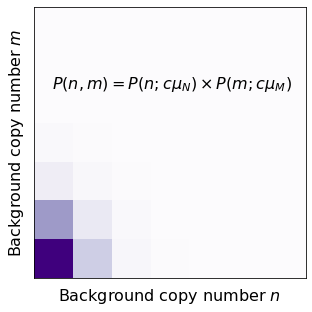

In [518]:

Y = np.outer(y1,y2)
plt.figure(figsize=(5,5))
ax = plt.gca()
plt.imshow((Y),cmap='Purples')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Background copy number $n$',fontsize=fs+4)
plt.ylabel(r'Background copy number $m$',fontsize=fs+4)
ax.text(0.95,0.7,r'$P(n,m) = P(n;c\mu_N)\times P(m;c\mu_M)$',transform=ax.transAxes,fontsize=fs+4,horizontalalignment='right')

# plt.savefig('nbprod.png',dpi=450,transparent=True)

     


In [485]:
y1

array([1., 0., 0., 0., 0., 0., 0.])

In [486]:
y2

array([8.60707976e-01, 1.29106196e-01, 9.68296473e-03, 4.84148237e-04,
       1.81555589e-05, 5.44666766e-07, 1.36166692e-08])

In [480]:
y1

array([1., 0., 0., 0., 0., 0., 0.])